<a href="https://colab.research.google.com/github/GermanOmar/ANN1/blob/main/GBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GRADIENT BOOSTING REGRESSOR

In [1]:
!pip install -q "tqdm>=4.36.1"
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1MB 3.3MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [3]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import tensorflow_addons as tfa
from sklearn.inspection import permutation_importance

In [4]:
data = pd.read_table('DATA.txt', header=None) 
data.describe()

,0,1,2,3,4,5
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,151.666731,760.617500,0.031154,0.089615,34.852308,97.635865
std,57.027410,441.185814,0.012012,0.026946,5.383197,1.876156
min,70.000000,111.000000,0.020000,0.030000,16.000000,91.200000
25%,100.000000,400.000000,0.020000,0.077500,30.000000,96.950000
50%,150.000000,707.000000,0.030000,0.090000,35.500000,98.330000
75%,200.000000,1000.000000,0.040000,0.110000,38.000000,98.905000
max,300.000000,2000.000000,0.050000,0.150000,48.000000,99.900000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e4a08f5c0>,
      dtype=object)

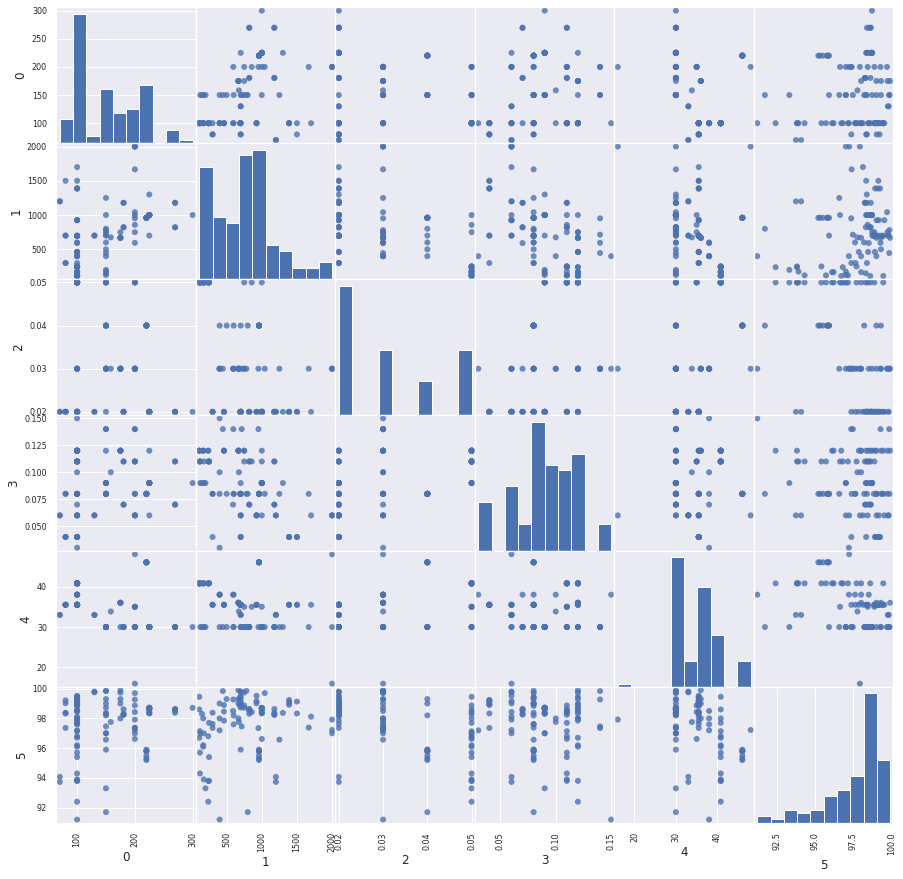

In [5]:
from pandas.plotting import scatter_matrix
import seaborn as sns
sns.set()
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (15,15))

In [6]:
X=data.loc[:,0:4]
Y=data.loc[:,5]

print(Y)

0      95.90
1      95.70
2      98.90
3      98.84
4      98.68
       ...  
99     98.71
100    99.21
101    95.20
102    98.25
103    99.90
Name: 5, Length: 104, dtype: float64


In [7]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu


X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.19, random_state=32)
print('training samples:', X_train.shape[0], 'test samples:', X_test.shape[0])


training samples: 83 test samples: 21


HYPERPARAMETERS:

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 4000, 'max_depth': None, 'min_samples_split': 5, 'max_leaf_nodes': 8,
          'learning_rate': 0.001, 'random_state': 12,'loss': 'ls'}
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
#model=GradientBoostingRegressor(n_estimators=1000, random_state=0, learning_rate=0.01, )
model = GradientBoostingRegressor(**params)


Training

In [18]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False, leave_overall_progress = True)

history = model.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


The mean squared error (MSE) on test set: 0.2545


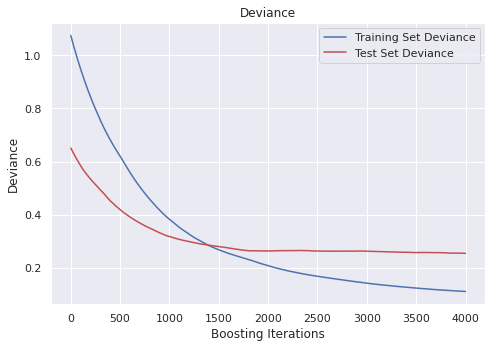

In [19]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Eval:

MSE train: 0.11064214628176185
MSE test: 0.25448844957398387
MSE train < MSE test? True

R2_train:  0.8972015047667549
R2_test:  0.6070228143095682


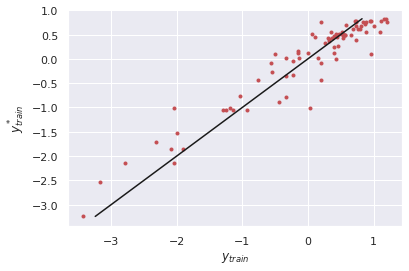

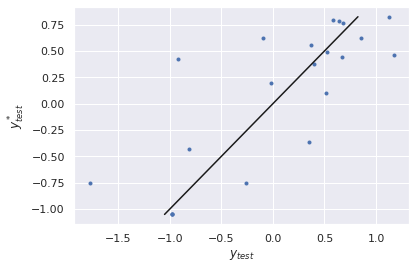

In [20]:

#PREDICTION
y_star_train = model.predict(X_train)
#y_star_val = model.predict(X_val)
y_star_test = model.predict(X_test)

#plotting...
plt.figure()
plt.plot(y_train, y_star_train, 'r.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_star_test, 'b.')
plt.plot([y_star_test.min(), y_star_test.max()], [y_star_test.min(), y_star_test.max()], 'k')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')

from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_star_test)
MSE_train = mean_squared_error(y_train, y_star_train)

print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_star_test)
print('R2_test: ',R2_test)